## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

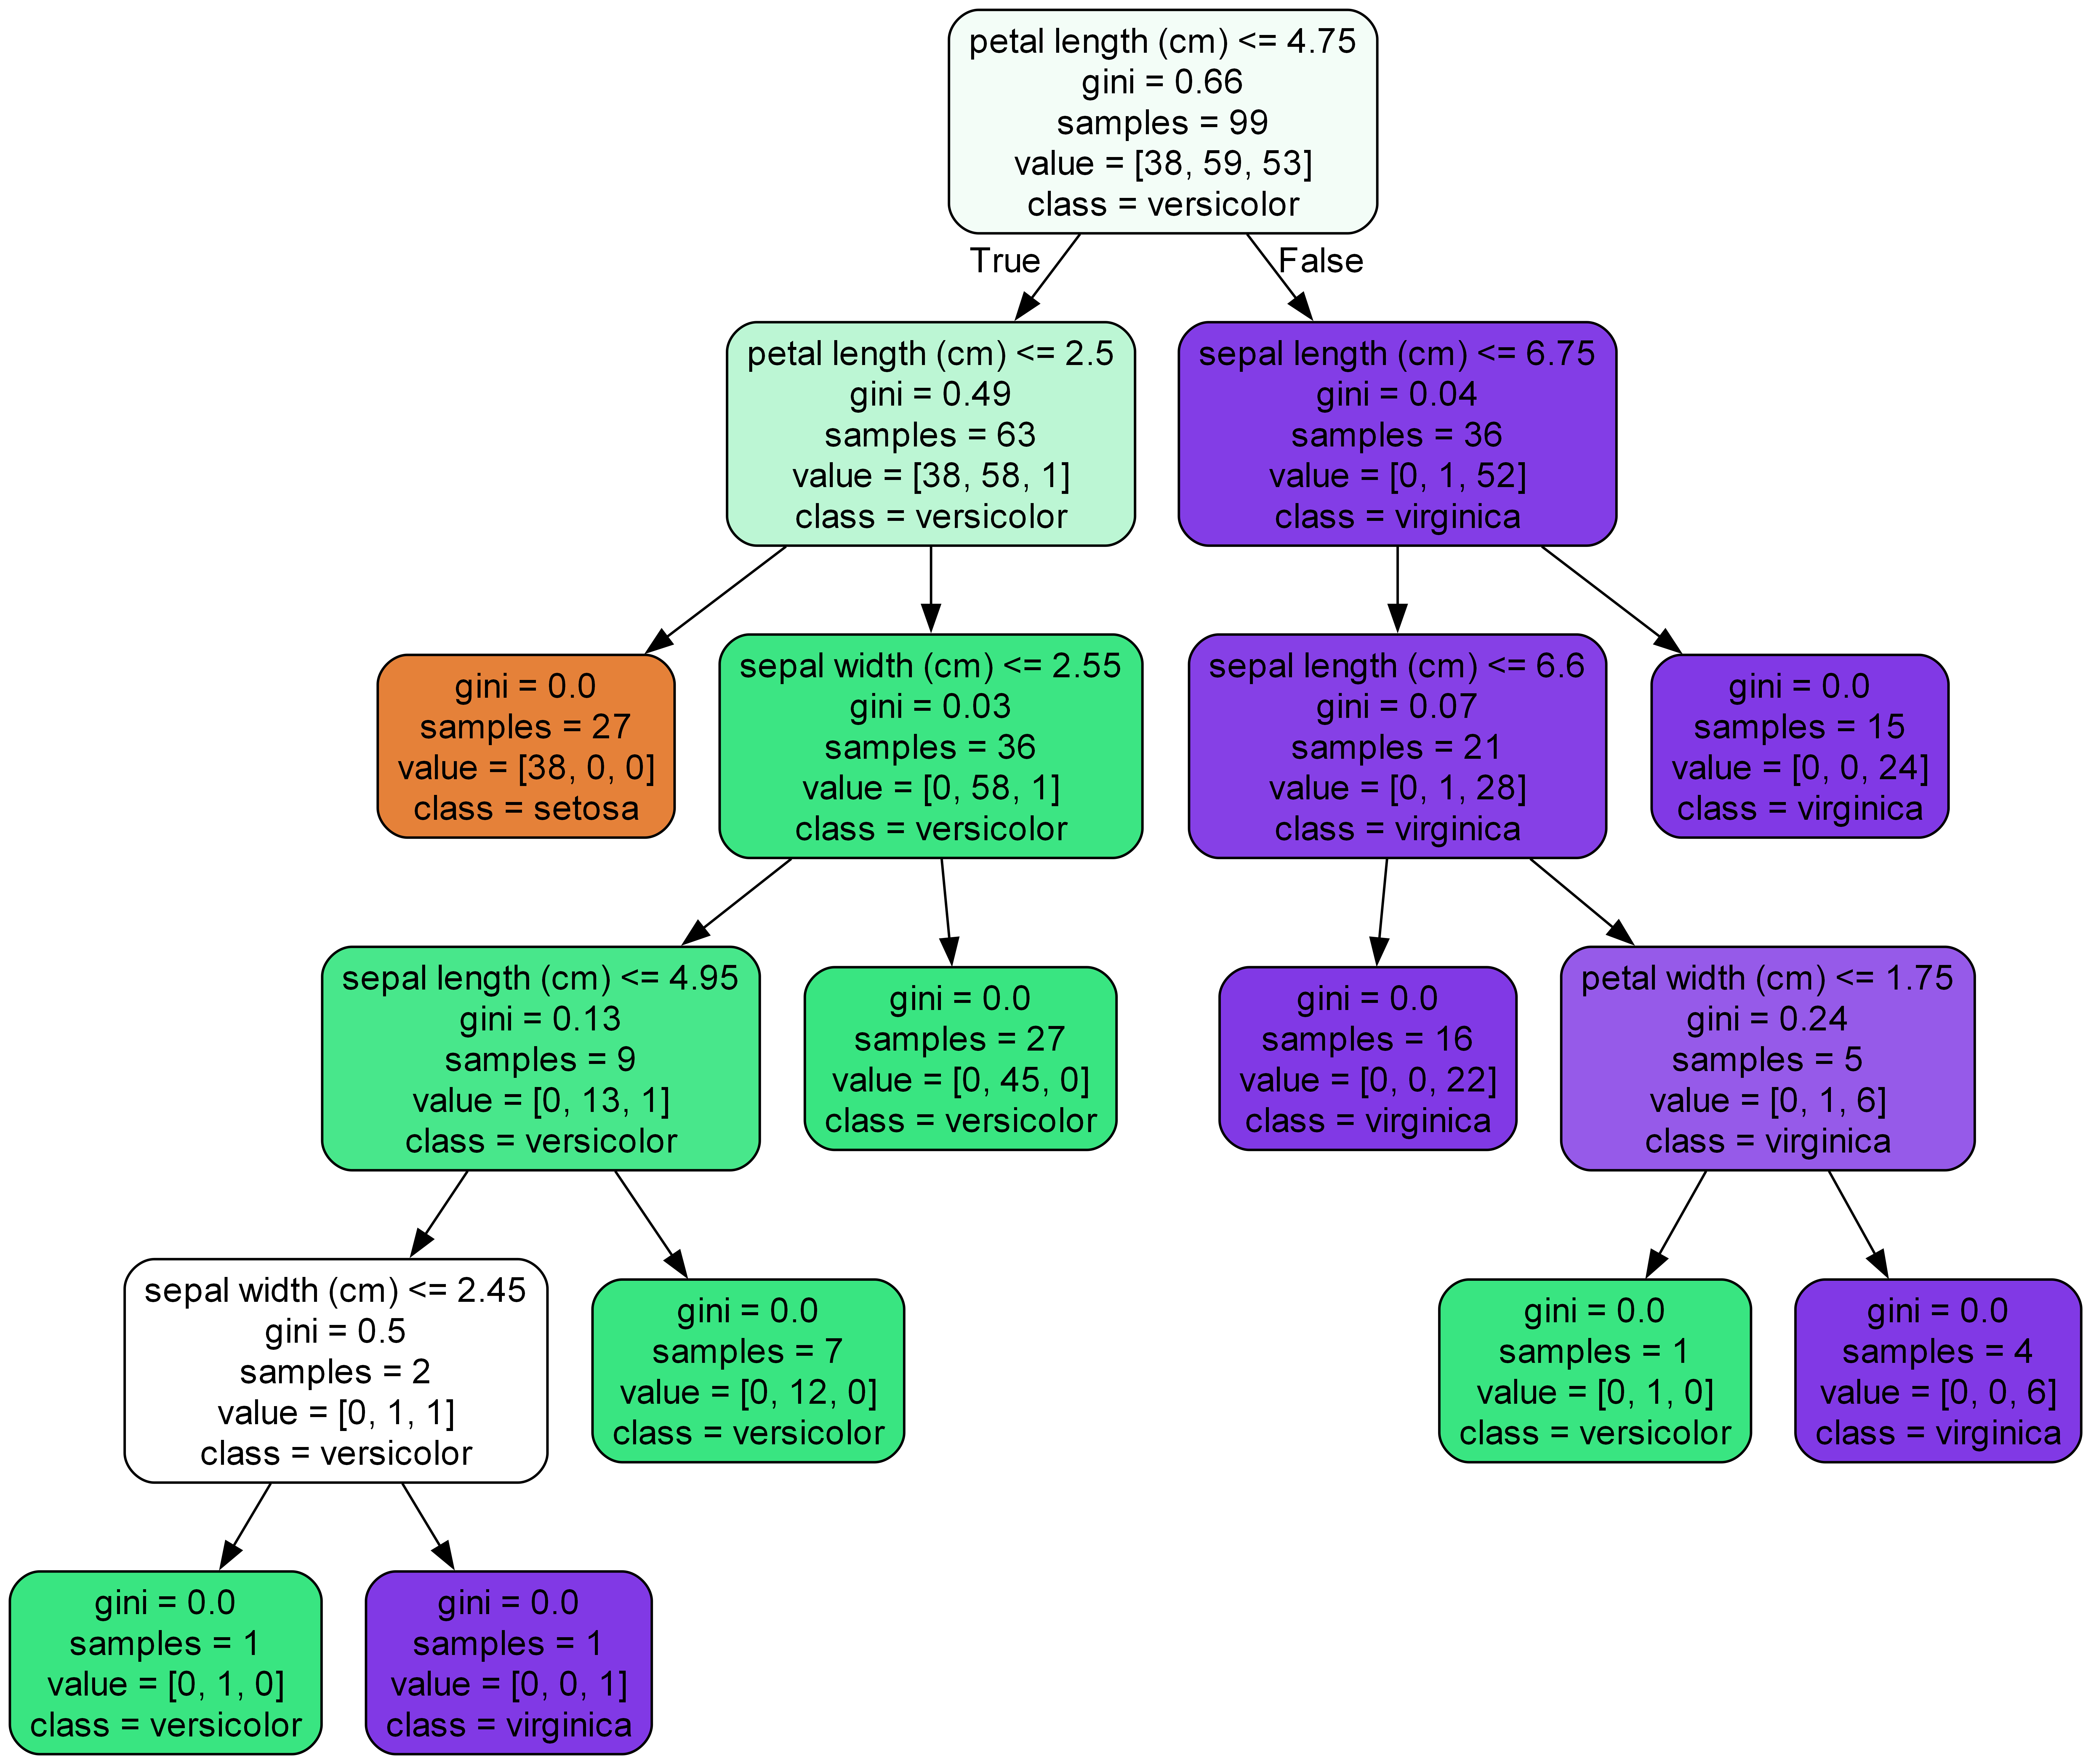

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [3]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [4]:
df.shape

(2218, 18)

In [5]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [6]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [17]:
df['n_age'] = 2020 - df['birth_year']

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [21]:
df.isna().sum()

patient_id            0
global_num          904
sex                 145
birth_year          454
age                 261
country               0
province              0
city                 65
disease            2199
infection_case     1055
infection_order    2176
infected_by        1749
contact_number     1807
state                88
n_age               454
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [32]:
df['disease'].fillna(0, inplace = True)


In [35]:
df['disease'].replace(True, 1, inplace = True)

In [36]:
df['disease'].value_counts()

0    2199
1      19
Name: disease, dtype: int64

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [39]:
df['global_num'].fillna(df['global_num'].mean(), inplace = True)
df['birth_year'].fillna(df['birth_year'].mean(), inplace = True)
df['infection_order'].fillna(df['infection_order'].mean(), inplace = True)
df['infected_by'].fillna(df['infected_by'].mean(), inplace = True)
df['contact_number'].fillna(df['contact_number'].mean(), inplace = True)

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       2218 non-null   int64  
 1   global_num       2218 non-null   float64
 2   sex              2073 non-null   object 
 3   birth_year       2218 non-null   float64
 4   age              1957 non-null   object 
 5   country          2218 non-null   object 
 6   province         2218 non-null   object 
 7   city             2153 non-null   object 
 8   disease          2218 non-null   int64  
 9   infection_case   1163 non-null   object 
 10  infection_order  2218 non-null   float64
 11  infected_by      2218 non-null   float64
 12  contact_number   2218 non-null   float64
 13  state            2130 non-null   object 
 14  n_age            1764 non-null   float64
dtypes: float64(6), int64(2), object(7)
memory usage: 260.0+ KB


In [189]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,released,56.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,released,33.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,released,56.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,released,29.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,released,28.0


In [190]:
df.infected_by.value_counts()

2.600789e+09    1749
2.000000e+09      44
4.100000e+09      27
4.100000e+09      21
2.000000e+09      17
                ... 
2.000000e+09       1
2.000000e+09       1
2.000000e+09       1
2.002000e+09       1
6.113000e+09       1
Name: infected_by, Length: 207, dtype: int64

In [49]:
features = ['sex', 'age', 'city', 'infection_case', 'state', 'n_age']


In [82]:
for feature in features:
    df[feature].fillna(df[feature].mode()[0], inplace = True)

 **<font color='teal'> Check for any remaining null values.</font>**

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       2218 non-null   int64  
 1   global_num       2218 non-null   float64
 2   sex              2218 non-null   object 
 3   birth_year       2218 non-null   float64
 4   age              2218 non-null   object 
 5   country          2218 non-null   object 
 6   province         2218 non-null   object 
 7   city             2218 non-null   object 
 8   disease          2218 non-null   int64  
 9   infection_case   2218 non-null   object 
 10  infection_order  2218 non-null   float64
 11  infected_by      2218 non-null   float64
 12  contact_number   2218 non-null   float64
 13  state            2218 non-null   object 
 14  n_age            2218 non-null   float64
dtypes: float64(6), int64(2), object(7)
memory usage: 260.0+ KB


In [133]:
df.infection_case.value_counts()

contact with patient                1585
etc                                  220
Guro-gu Call Center                  102
Shincheonji Church                    86
overseas inflow                       61
Onchun Church                         33
gym facility in Cheonan               30
Ministry of Oceans and Fisheries      27
Cheongdo Daenam Hospital              21
Dongan Church                         17
Eunpyeong St. Mary's Hospital         14
Seongdong-gu APT                      13
gym facility in Sejong                 4
Suyeong-gu Kindergarten                3
River of Grace Community Church        1
Pilgrimage to Israel                   1
Name: infection_case, dtype: int64

In [191]:
df_drop = df.drop(columns = ['patient_id', 'global_num', 'birth_year', 'age', 'city','infection_order'])

In [140]:
top_5 = dict(df.infection_case.value_counts())
top_5

{'contact with patient': 1585,
 'etc': 220,
 'Guro-gu Call Center': 102,
 'Shincheonji Church': 86,
 'overseas inflow': 61,
 'Onchun Church': 33,
 'gym facility in Cheonan': 30,
 'Ministry of Oceans and Fisheries': 27,
 'Cheongdo Daenam Hospital': 21,
 'Dongan Church': 17,
 "Eunpyeong St. Mary's Hospital": 14,
 'Seongdong-gu APT': 13,
 'gym facility in Sejong': 4,
 'Suyeong-gu Kindergarten': 3,
 'River of Grace Community Church': 1,
 'Pilgrimage to Israel': 1}

In [143]:
infect_case_top_5 = [x for x in top_5.keys() if top_5[x] > 60 ]
infect_case_top_5

['contact with patient',
 'etc',
 'Guro-gu Call Center',
 'Shincheonji Church',
 'overseas inflow']

In [148]:
df_drop.infection_case = df_drop.infection_case.map(lambda x: x if x in infect_case_top_5 else 'other')

In [205]:
df_drop.state.value_counts()

isolated    1879
released     307
deceased      32
Name: state, dtype: int64

In [206]:
df_drop.state = df_drop.state.map({'isolated': 0, 'released': 1, 'deceased': 2})

In [210]:
df_drop.state.astype('int64')

0       1
1       1
2       1
3       1
4       1
       ..
2213    0
2214    0
2215    1
2216    1
2217    0
Name: state, Length: 2218, dtype: int64

In [211]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             2218 non-null   object 
 1   country         2218 non-null   object 
 2   province        2218 non-null   object 
 3   disease         2218 non-null   int64  
 4   infection_case  2218 non-null   object 
 5   infected_by     2218 non-null   float64
 6   contact_number  2218 non-null   float64
 7   state           2218 non-null   int64  
 8   n_age           2218 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 156.1+ KB


Remove date columns from the data.


In [212]:
df_drop_expand = pd.get_dummies(df_drop, drop_first = True)

In [213]:
df_drop_expand

,disease,infected_by,contact_number,state,n_age,sex_male,country_Korea,country_Mongolia,country_Thailand,province_Chungcheongbuk-do,...,infection_case_Pilgrimage to Israel,infection_case_River of Grace Community Church,infection_case_Seongdong-gu APT,infection_case_Shincheonji Church,infection_case_Suyeong-gu Kindergarten,infection_case_contact with patient,infection_case_etc,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_overseas inflow
0,0,2.600789e+09,75.000000,1,56.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,2.600789e+09,31.000000,1,33.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,2.002000e+09,17.000000,1,56.0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,2.600789e+09,9.000000,1,29.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1.000000e+09,2.000000,1,28.0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213,0,2.600789e+09,24.128954,0,30.0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2214,0,2.600789e+09,87.000000,0,22.0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2215,0,2.600789e+09,84.000000,1,22.0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2216,0,2.600789e+09,21.000000,1,48.0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [214]:
df_drop_expand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 40 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   disease                                          2218 non-null   int64  
 1   infected_by                                      2218 non-null   float64
 2   contact_number                                   2218 non-null   float64
 3   state                                            2218 non-null   int64  
 4   n_age                                            2218 non-null   float64
 5   sex_male                                         2218 non-null   uint8  
 6   country_Korea                                    2218 non-null   uint8  
 7   country_Mongolia                                 2218 non-null   uint8  
 8   country_Thailand                                 2218 non-null   uint8  
 9   province_Chungcheongbuk-do    

Review the count of unique values by column.

In [215]:
print(df_drop_expand.nunique())

disease                                              2
infected_by                                        207
contact_number                                      73
state                                                3
n_age                                               96
sex_male                                             2
country_Korea                                        2
country_Mongolia                                     2
country_Thailand                                     2
province_Chungcheongbuk-do                           2
province_Chungcheongnam-do                           2
province_Daegu                                       2
province_Daejeon                                     2
province_Gangwon-do                                  2
province_Gwangju                                     2
province_Gyeonggi-do                                 2
province_Gyeongsangbuk-do                            2
province_Gyeongsangnam-do                            2
province_I

Review the percent of unique values by column.

In [216]:
print(df_drop_expand.nunique()/df.shape[0])

disease                                            0.000902
infected_by                                        0.093327
contact_number                                     0.032913
state                                              0.001353
n_age                                              0.043282
sex_male                                           0.000902
country_Korea                                      0.000902
country_Mongolia                                   0.000902
country_Thailand                                   0.000902
province_Chungcheongbuk-do                         0.000902
province_Chungcheongnam-do                         0.000902
province_Daegu                                     0.000902
province_Daejeon                                   0.000902
province_Gangwon-do                                0.000902
province_Gwangju                                   0.000902
province_Gyeonggi-do                               0.000902
province_Gyeongsangbuk-do               

Review the range of values per column.

In [217]:
df_drop_expand.describe().T

,count,mean,std,min,25%,50%,75%,max
disease,2218.0,8.566276e-03,9.217769e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infected_by,2218.0,2.600789e+09,7.216328e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2218.0,2.412895e+01,3.917141e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
state,2218.0,1.672678e-01,4.101463e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
n_age,2218.0,4.623715e+01,1.747912e+01,0.000000e+00,3.200000e+01,5.100000e+01,5.500000e+01,1.040000e+02
sex_male,2218.0,4.066727e-01,4.913236e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
country_Korea,2218.0,9.945897e-01,7.337190e-02,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
country_Mongolia,2218.0,4.508566e-04,2.123338e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
country_Thailand,2218.0,4.508566e-04,2.123338e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
province_Chungcheongbuk-do,2218.0,1.262399e-02,1.116702e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


### Check for duplicated rows

In [218]:
duplicateRowsDF = df_drop_expand[df_drop_expand.duplicated()]
duplicateRowsDF

,disease,infected_by,contact_number,state,n_age,sex_male,country_Korea,country_Mongolia,country_Thailand,province_Chungcheongbuk-do,...,infection_case_Pilgrimage to Israel,infection_case_River of Grace Community Church,infection_case_Seongdong-gu APT,infection_case_Shincheonji Church,infection_case_Suyeong-gu Kindergarten,infection_case_contact with patient,infection_case_etc,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_overseas inflow
11,0,2.600789e+09,0.000000,1,28.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
65,0,2.600789e+09,24.128954,1,34.0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
106,0,2.600789e+09,24.128954,0,35.0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
136,0,2.600789e+09,24.128954,0,51.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
145,0,2.600789e+09,24.128954,0,51.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,0,2.600789e+09,24.128954,0,45.0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2207,0,2.600789e+09,24.128954,0,26.0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2208,0,2.600789e+09,24.128954,1,51.0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2212,0,2.600789e+09,24.128954,0,49.0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [219]:
no_dupes = df_drop_expand.drop_duplicates()

In [220]:
no_dupes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1357 entries, 0 to 2217
Data columns (total 40 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   disease                                          1357 non-null   int64  
 1   infected_by                                      1357 non-null   float64
 2   contact_number                                   1357 non-null   float64
 3   state                                            1357 non-null   int64  
 4   n_age                                            1357 non-null   float64
 5   sex_male                                         1357 non-null   uint8  
 6   country_Korea                                    1357 non-null   uint8  
 7   country_Mongolia                                 1357 non-null   uint8  
 8   country_Thailand                                 1357 non-null   uint8  
 9   province_Chungcheongbuk-do    

Print the categorical columns and their associated levels.

In [98]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,2
1,age,11
2,country,4
3,province,17
4,city,134
5,infection_case,16
6,state,3


**<font color='teal'> Plot the correlation heat map for the features.</font>**

<AxesSubplot:>

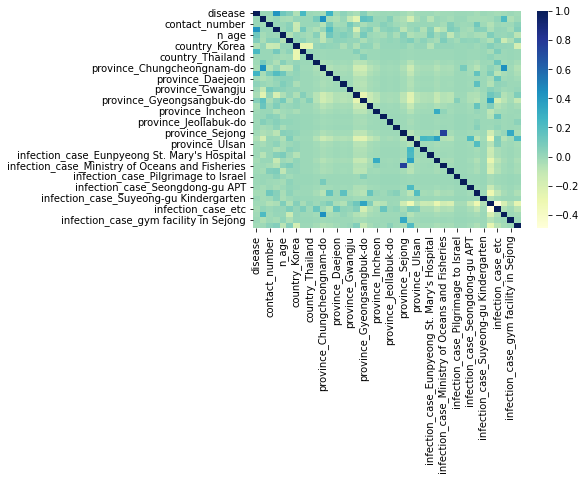

In [221]:
import seaborn as sns
sns.heatmap(no_dupes.corr(), cmap="YlGnBu", annot=False)

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

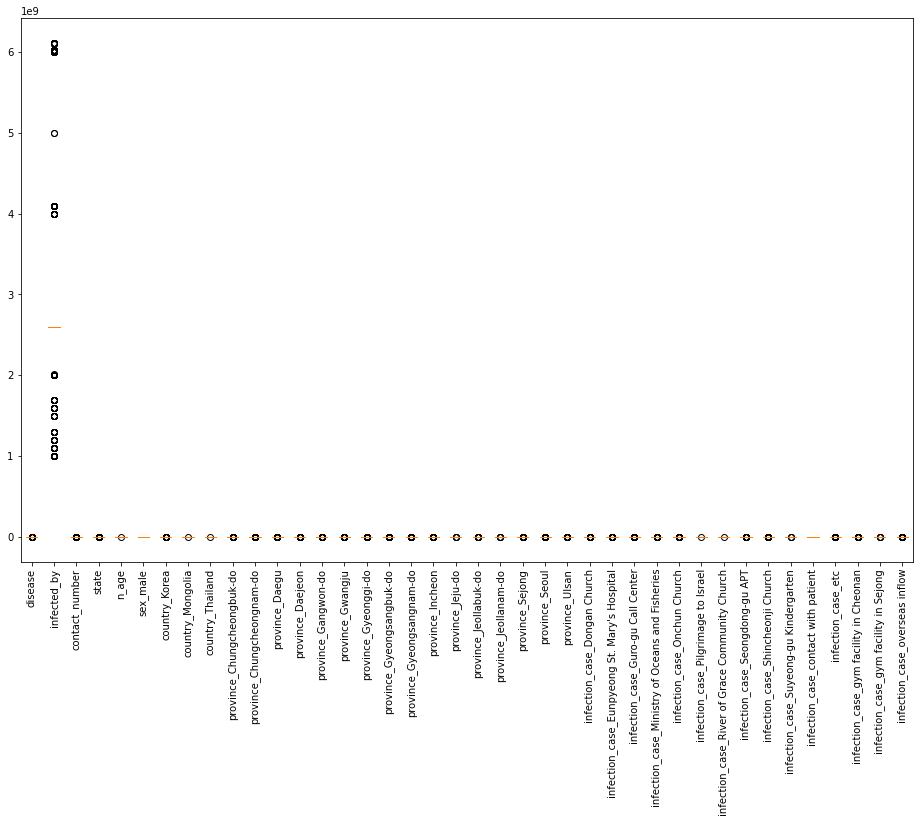

In [235]:
fig, ax1 = plt.subplots(figsize=(16,10))
ax1.boxplot(no_dupes, notch = False, sym = 'o', vert = True, whis = 1.5)
ax1.set_xticklabels(no_dupes.columns, rotation = 90)
plt.show()

**<font color='teal'> Create dummy features for object type features. </font>**

Dummy features were created in previous steps.

### Split the data into test and train subsamples

In [223]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y
X = no_dupes.drop(columns = 'state')
y = no_dupes['state']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [224]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [225]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss


### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [226]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.739
Random Forest: f1-score=0.726


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [184]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[185  29   0]
 [ 41  13   0]
 [  1   0   3]]
Normalized confusion matrix
[[0.86 0.14 0.  ]
 [0.76 0.24 0.  ]
 [0.25 0.   0.75]]


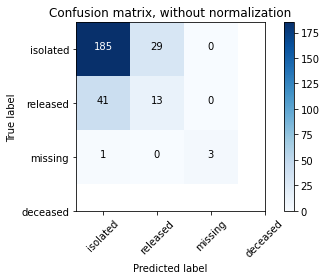

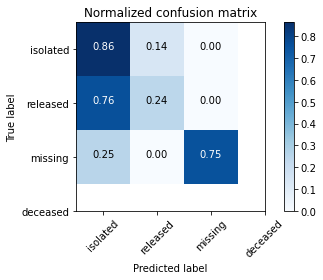

In [227]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


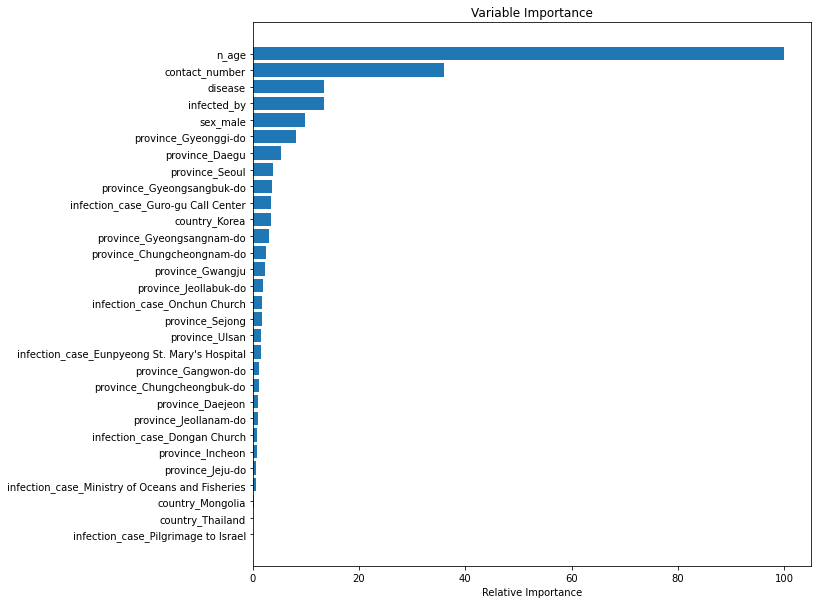

In [228]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.